<a href="https://colab.research.google.com/github/sandeep0412/EthereumTokenClassification/blob/master/TokenClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification of Ethereum based tokens on their Return on Investment

To determine the ICO returns and classify ICOs based on how much return is expected, we have divided the problem into 2 stages:
1. Ethereum Price Prediction
2. ICO Returns Classification

## Ethereum Price Prediction

** - In this stage, core Ethereum variables are calculated from Ethereum Blockchain dataset, Ethereum prices in USD, and number of ICOs on each day since 2015 is scraped from websites. Ethereum prices are predicted using two Neural Network models - Simple ANN and Neural network with LSTM**

### Data Exploration

Stage 1 imports all required libraries for the project and initiating client connection to bigquery
"google.cloud.bigquery" libraries are used to access bigquery data in local project
"pandas" library is used for converting the data filtered from bigquery to dataframes
"plotly" graphing library is used for visualization

In [0]:
from google.cloud import bigquery
from google.colab import drive
from google.oauth2 import service_account
import pandas as pd
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
import numpy as np
import collections

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.colors as colors
%matplotlib inline


drive.mount('/content/drive')
#!ls "/content/drive/My Drive/Colab Notebooks"
credentials = service_account.Credentials.from_service_account_file('/content/drive/My Drive/Colab Notebooks/ICOAnalysis-a8d907cf91f4.json')
project_id = 'icoanalysis-225316'
client = bigquery.Client(credentials= credentials,project=project_id)
plotly.tools.set_credentials_file(username = 'sandeep.panigrahy7', api_key = '************')
#client = bigquery.Client()
#print("Stage 1")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Stage 2 : Query to calculate average transaction cost of all transactions

In [0]:
query_ether_supply = """with ether_emitted_by_date  as (
  select date(block_timestamp) as Tx_Date, sum(value) as value
  from `bigquery-public-data.ethereum_blockchain.traces`
  where trace_type in ('genesis', 'reward') AND date(block_timestamp) >'2015-08-06'
  group by date(block_timestamp)
)
select Tx_Date, sum(value) OVER (ORDER BY Tx_Date) / power(10, 18) AS supply
from ether_emitted_by_date"""
query_job = client.query(query_ether_supply)
iterator = query_job.result(timeout=None)
rows = list(iterator)

# Transform the rows into a nice pandas dataframe
df_supply = pd.DataFrame(data=[list(x.values()) for x in rows], columns=list(rows[0].keys()))
print(df_supply.head(5))

      Tx_Date        supply
0  2015-08-07   27437.65625
1  2015-08-08   55381.09375
2  2015-08-09   82559.37500
3  2015-08-10  110376.71875
4  2015-08-11  138404.53125


In [0]:
query_avg = """SELECT SUM(value/POWER(10,18)) AS sum_tx_ether, AVG(gas_price*(receipt_gas_used/POWER(10,18))) AS avg_tx_gas_cost,
DATE(block_timestamp) AS Tx_Date FROM `bigquery-public-data.ethereum_blockchain.transactions` AS transactions, `bigquery-public-data.ethereum_blockchain.blocks` AS blocks
WHERE TRUE AND transactions.block_number = blocks.number AND value > 0 GROUP BY Tx_Date ORDER BY Tx_Date """
#print(query_avg)
query_job = client.query(query_avg)
iterator = query_job.result(timeout=None)
rows = list(iterator)

# Transform the rows into a nice pandas dataframe
df_sum = pd.DataFrame(data=[list(x.values()) for x in rows], columns=list(rows[0].keys()))
print(df_sum.head(5))


   sum_tx_ether  avg_tx_gas_cost     Tx_Date
0  2.008723e+06         0.012115  2015-08-07
1  1.358322e+07         0.029071  2015-08-08
2  1.165455e+06         0.010648  2015-08-09
3  1.670911e+06         0.018447  2015-08-10
4  1.485732e+06         0.002147  2015-08-11


In [0]:
layout = go.Layout(title="Average Ether transaction cost over time",
                xaxis=dict(title='Date'),
                yaxis=dict(title='Average GAS Cost'))

data1 = [go.Bar(x=df_sum.Tx_Date, y=df_sum.avg_tx_gas_cost)]
py.iplot(data1, layout=layout, filename='jupyter-basic_bar')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~sandeep.panigrahy7/0 or inside your plot.ly account where it is named 'jupyter-basic_bar'


Stage 3: Query to identify spam transactions in Ethereum Blockchain. Authorization addresses are matched and their verification status is checked from multiple tables of "transactions" and "token_transfers". 

In [0]:
query_spam = """ with transfers_and_authorizing_transactions as (
  with external_accounts as (
    select distinct(from_address) as address
    from `bigquery-public-data.ethereum_blockchain.transactions` as transactions
  ),
  authorizing_transactions as (
    select from_address, to_address, min(block_number) as block_number
    from `bigquery-public-data.ethereum_blockchain.transactions` as transactions
    group by from_address, to_address
  )
  select token_transfers.transaction_hash as transaction_hash, 
    token_transfers.log_index as log_index, 
    authorizing_transactions.block_number as authorizing_block_number
  from `bigquery-public-data.ethereum_blockchain.token_transfers` as token_transfers
  join external_accounts on external_accounts.address = token_transfers.from_address
  left join authorizing_transactions
    on authorizing_transactions.from_address =  token_transfers.from_address
    and authorizing_transactions.to_address = token_transfers.token_address
    and authorizing_transactions.block_number <= token_transfers.block_number
  where  token_transfers.from_address != '0x0000000000000000000000000000000000000000'
)
select transaction_hash, log_index
from transfers_and_authorizing_transactions
where authorizing_block_number is null
order by log_index desc
limit 100"""
query_job = client.query(query_spam)
iterator = query_job.result(timeout=None)
rows = list(iterator)

df_spam = pd.DataFrame(data=[list(x.values()) for x in rows], columns=list(rows[0].keys()))
df_spam.head(5)

,transaction_hash,log_index
0,0x22592b0547d06808f93dc6ed135ca88db6d0c4f62545...,2015
1,0x43325dfbcec2489ff40ca26b2e6905b12a42711c6072...,2015
2,0x3108f527a534b4f905b43dd053ec4a9b6d08c78cf873...,2014
3,0x53ae910e140249ae3bdc8478479f208dbd9bc49f3280...,2014
4,0xfedaad0bf2156d9118b6ee84fd34c5ef692a76edc8bf...,2013


In [0]:
query_spam_count = ''' with transfers_and_authorizing_transactions as (
  with external_accounts as (
    select distinct(from_address) as address
    from `bigquery-public-data.ethereum_blockchain.transactions` as transactions
  ),
  authorizing_transactions as (
    select from_address, to_address, min(block_number) as block_number
    from `bigquery-public-data.ethereum_blockchain.transactions` as transactions
    group by from_address, to_address
  )
  select token_transfers.transaction_hash as transaction_hash, 
    token_transfers.log_index as log_index, 
    authorizing_transactions.block_number as authorizing_block_number
  from `bigquery-public-data.ethereum_blockchain.token_transfers` as token_transfers
  join external_accounts on external_accounts.address = token_transfers.from_address
  left join authorizing_transactions
    on authorizing_transactions.from_address =  token_transfers.from_address
    and authorizing_transactions.to_address = token_transfers.token_address
    and authorizing_transactions.block_number <= token_transfers.block_number
  where  token_transfers.from_address != '0x0000000000000000000000000000000000000000'
)
select log_index, count(*) as spam_count
from transfers_and_authorizing_transactions
where authorizing_block_number is null
GROUP BY log_index
ORDER BY spam_count DESC
LIMIT 100'''
query_job = client.query(query_spam_count)
iterator = query_job.result(timeout=None)
rows = list(iterator)

df_spam_count = pd.DataFrame(data=[list(x.values()) for x in rows], columns=list(rows[0].keys()))
print(df_spam_count.head(5))

data_spam_count = [go.Scatter(x= df_spam_count.log_index, y=df_spam_count.spam_count, mode = 'markers')]
py.iplot(data_spam_count, layout=layout, filename='basic-scatter')

   log_index  spam_count
0          2       17622
1          6        9624
2         10        8628
3         14        8576
4         18        8460


Stage 4: Query to analyze how many spam_transactions are done using single "transaction_hash".
This query will help us find time period of spammed transactions processed, and their event behind it.

In [0]:
query_spam_date_count = ''' with transfers_and_authorizing_transactions as (
  with external_accounts as (
    select distinct(from_address) as address,
    DATE(block_timestamp) AS Tx_Date
    from `bigquery-public-data.ethereum_blockchain.transactions` as transactions
  ),
  authorizing_transactions as (
    select from_address, to_address, min(block_number) as block_number
    from `bigquery-public-data.ethereum_blockchain.transactions` as transactions
    group by from_address, to_address
  )
  select token_transfers.transaction_hash as transaction_hash, 
    token_transfers.log_index as log_index, 
    external_accounts.Tx_Date as Tx_Date,
    authorizing_transactions.block_number as authorizing_block_number
  from `bigquery-public-data.ethereum_blockchain.token_transfers` as token_transfers
  join external_accounts on external_accounts.address = token_transfers.from_address
  left join authorizing_transactions
    on authorizing_transactions.from_address =  token_transfers.from_address
    and authorizing_transactions.to_address = token_transfers.token_address
    and authorizing_transactions.block_number <= token_transfers.block_number
  where  token_transfers.from_address != '0x0000000000000000000000000000000000000000'
)
select Tx_Date, count(*) as spam_count
from transfers_and_authorizing_transactions
where authorizing_block_number is null
GROUP BY Tx_Date
ORDER BY Tx_Date'''
query_job = client.query(query_spam_date_count)
iterator = query_job.result(timeout=None)
rows = list(iterator)

df_spam_date_count = pd.DataFrame(data=[list(x.values()) for x in rows], columns=list(rows[0].keys()))
print(df_spam_date_count.head(5))

      Tx_Date  spam_count
0  2015-08-07          22
1  2015-08-08          28
2  2015-08-09          15
3  2015-08-10        1134
4  2015-08-11        1140


In [0]:
query_hashrate = """ WITH Tx_Data AS (SELECT
  DATE(timestamp) as Tx_Date,
  COUNT(number) as Block_Count,
  AVG(difficulty)/POWER(10,9) as Difficulty,
  86400/COUNT(number) as AVG_TIME,
  (AVG(difficulty)/(86400/COUNT(number))/POWER(10,9)) as NetHashRate
FROM
  `bigquery-public-data.ethereum_blockchain.blocks`
WHERE
  DATE(timestamp) > '2015-08-06'
GROUP BY
  DATE(timestamp))
 select * from Tx_Data
 ORDER BY Tx_Data.Tx_Date """
query_job = client.query(query_hashrate)
iterator = query_job.result(timeout=None)
rows = list(iterator)

df_hashrate = pd.DataFrame(data=[list(x.values()) for x in rows], columns=list(rows[0].keys()))
print(df_hashrate.head(5))
data_hashrate = [go.Bar(x= df_hashrate.Tx_Date, y=df_hashrate.NetHashRate)]
py.iplot(data_hashrate, layout=layout, filename='basic-scatter')

      Tx_Date  Block_Count   Difficulty   AVG_TIME  NetHashRate
0  2015-08-07         5189  1470.838651  16.650607    88.335437
1  2015-08-08         5256  1586.123529  16.438356    96.489181
2  2015-08-09         5123  1709.479787  16.865118   101.361863
3  2015-08-10         5255  1837.695763  16.441484   111.771889
4  2015-08-11         5280  2036.390798  16.363636   124.446104


Merge all dataframes

In [0]:
df_temp = df_spam_date_count.sort_values(['Tx_Date'])
len(df_temp)
df_hashrate = pd.merge(df_hashrate,df_temp, how='inner', on='Tx_Date')
df_hashrate = pd.merge(df_hashrate,df_sum, how='inner', on='Tx_Date')
df_hashrate = pd.merge(df_hashrate,df_supply, how='inner', on='Tx_Date')
list(df_hashrate)

['Tx_Date',
 'Block_Count',
 'Difficulty',
 'AVG_TIME',
 'NetHashRate',
 'spam_count',
 'sum_tx_ether',
 'avg_tx_gas_cost',
 'supply']

### Data Preparation

Get Historical Ethereum daily Price 

In [0]:
import json 
import requests 
from datetime import datetime as utod
import datetime
date1 = datetime.datetime(2017,4,1,0,0).timestamp()
url ='https://min-api.cryptocompare.com/data/histoday?fsym=ETH&tsym=USD&allData=true'
request = requests.get(url).json()
data = request['Data']
for i in data:
    i['time'] = utod.fromtimestamp(i['time']).strftime('%Y-%m-%d')

Sort by date and merge with dataframe

In [0]:
temp_val = []
for i in data:
  temp_val.append(i['close'])
temp_val.pop()
#temp_val.pop() #uncomment when error
#print(len(temp_val))
#print(df_hashrate['Tx_Date'].count())
#print(df_hashrate['Tx_Date'])
#print(temp_val)
df_hashrate['price'] = temp_val
print(df_hashrate.head(5))

      Tx_Date  Block_Count   Difficulty   AVG_TIME  NetHashRate  spam_count  \
0  2015-08-07         5189  1470.838651  16.650607    88.335437          22   
1  2015-08-08         5256  1586.123529  16.438356    96.489181          28   
2  2015-08-09         5123  1709.479787  16.865118   101.361863          15   
3  2015-08-10         5255  1837.695763  16.441484   111.771889        1134   
4  2015-08-11         5280  2036.390798  16.363636   124.446104        1140   

   sum_tx_ether  avg_tx_gas_cost        supply  price  
0  2.008723e+06         0.012115   27437.65625   3.00  
1  1.358322e+07         0.029071   55381.09375   1.20  
2  1.165455e+06         0.010648   82559.37500   1.20  
3  1.670911e+06         0.018447  110376.71875   1.20  
4  1.485732e+06         0.002147  138404.53125   0.99  


In [0]:
df_hashrate1 = df_hashrate.copy()

Get list and details of all ICO

In [0]:
import requests
import json
import os
import pandas as pd

url = 'https://api.icowatchlist.com/public/v1/finished'

#print(url)

response = requests.get(url)

# could write this to a file
parsed = json.loads(response.text)

new_json = json.dumps(parsed["ico"]["finished"])
df_ico = pd.read_json(new_json)
df_ico =df_ico.filter(items=['name','all_time_roi','coin_symbol','end_time','start_time','price_usd'])

In [0]:
df_ico = df_ico[df_ico.all_time_roi != 'NA']
df_ico = df_ico[df_ico.price_usd != 'NA']
df_ico.all_time_roi = df_ico.all_time_roi.apply(lambda x: x.split('.')[0]).replace(',', '', regex=True).apply(lambda x: int(x))
df_ico.end_time = df_ico.end_time.apply(lambda x: x.date())
df_ico.start_time = df_ico.start_time.apply(lambda x: x.date())
df_ico = df_ico[df_ico.start_time >= min(df_hashrate.Tx_Date)]

Group all ICOs by date

In [0]:
date_list ={}
daterange = pd.date_range(min(df_hashrate.Tx_Date), max(df_hashrate.Tx_Date))
for single_date in daterange:
  date_list[single_date.date()] = []
for index, row in df_ico.iterrows():
  daterange = pd.date_range(row[4], row[3])
  for single_date in daterange:
      date_list[single_date.date()].append(row[0])
 

In [0]:
print(date_list)

{datetime.date(2015, 8, 7): [], datetime.date(2015, 8, 8): [], datetime.date(2015, 8, 9): [], datetime.date(2015, 8, 10): [], datetime.date(2015, 8, 11): [], datetime.date(2015, 8, 12): [], datetime.date(2015, 8, 13): [], datetime.date(2015, 8, 14): [], datetime.date(2015, 8, 15): [], datetime.date(2015, 8, 16): [], datetime.date(2015, 8, 17): ['Augur'], datetime.date(2015, 8, 18): ['Augur'], datetime.date(2015, 8, 19): ['Augur'], datetime.date(2015, 8, 20): ['Augur'], datetime.date(2015, 8, 21): ['Augur'], datetime.date(2015, 8, 22): ['Augur'], datetime.date(2015, 8, 23): ['Augur'], datetime.date(2015, 8, 24): ['Augur'], datetime.date(2015, 8, 25): ['Augur'], datetime.date(2015, 8, 26): ['Augur'], datetime.date(2015, 8, 27): ['Augur'], datetime.date(2015, 8, 28): ['Augur'], datetime.date(2015, 8, 29): ['Augur'], datetime.date(2015, 8, 30): ['Augur'], datetime.date(2015, 8, 31): ['Augur'], datetime.date(2015, 9, 1): ['Augur'], datetime.date(2015, 9, 2): ['Augur'], datetime.date(2015, 9

Get Ratings of all ICO

In [0]:
#uploaded = files.upload()
# pip install BeautifulSoup4
from urllib.request import Request, urlopen
from bs4 import BeautifulSoup
import io

URL = 'https://icobench.com/ico/'

#df = pd.read_csv(io.StringIO(uploaded['df_ico.csv'].decode('utf-8')))

df_ico['ico_rating'] = None #adding a new column
count = 0

print(df_ico['name'].count())

for symbol in df_ico['name']:
    
    symbol_name = symbol.lower()
    
    #print("For : " + str(count+1)+" "+ URL + symbol.lower())
    
    if ' ' in symbol_name:
        names = []
        split_s = symbol_name.split()
        temp = ''
        
        for x in split_s:
            temp+=x;
        
        names.append(temp)
        
        temp = split_s[0]
        for k in range(1,len(split_s)):
            temp += '-' + split_s[k]
        
        names.append(temp)      
        #print(*names, sep = ", ")
           
        if(len(names) > 0):
            for m in range(0,len(names)):
                req = Request(URL + names[m].lower(), headers={'User-Agent': 'Mozilla/5.0'})

                #print("if " + URL + names[m].lower())

                webpage = urlopen(req).read()
                soup = BeautifulSoup(webpage, 'html.parser')
                ratings = soup.find('div', attrs={'class', 'rate color3'})
                if ratings is None:
                    ratings = soup.find('div', attrs={'class', 'rate color4'})
                if ratings is None:
                    ratings = soup.find('div', attrs={'class', 'rate color2'})
                if ratings is None:
                    ratings = soup.find('div', attrs={'class', 'rate color5'})
                if ratings is None:
                    print('NA '+ratings)
                    continue
                if ratings is not None:  
                    df_ico.loc[df_ico['name'] == symbol,['ico_rating']] = float(ratings.text.strip())
                    break
                ratings = None
    else:
        req = Request(URL + symbol.lower(), headers={'User-Agent': 'Mozilla/5.0'})
        webpage = urlopen(req).read()
        
        #print("else : "+ URL + symbol.lower())
        soup = BeautifulSoup(webpage, 'html.parser')

        ratings = soup.find('div', attrs={'class', 'rate color3'})
        if ratings is None:
            ratings = soup.find('div', attrs={'class', 'rate color4'})
        if ratings is None:
            ratings = soup.find('div', attrs={'class', 'rate color2'})
        if ratings is None:
            ratings = soup.find('div', attrs={'class', 'rate color5'}) 
        if ratings is None or ratings.text is None:
            #print("NA: "+ URL + symbol.lower())
            continue
        if ratings is not None:  
            df_ico.loc[df_ico['name'] == symbol,['ico_rating']] = float(ratings.text.strip())
        
        ratings = None

    count = count+1

print(df_ico.head(5))


245
        name  all_time_roi coin_symbol    end_time  start_time price_usd  \
0      Augur           880         REP  2015-10-01  2015-08-17      5.69   
1       Lisk          1413         LSK  2016-03-21  2016-02-22      1.13   
2  Digix DAO           303         DGD  2016-03-30  2016-03-30     13.06   
3      Waves          1193       WAVES  2016-05-31  2016-04-12      2.43   
4    Stratis          8490       STRAT  2016-07-26  2016-06-21      0.63   

  ico_rating  
0        3.7  
1        2.9  
2        2.3  
3        4.3  
4          4  


Save the dataset to csv

In [0]:
df_hashrate.to_csv('/content/drive/My Drive/Colab Notebooks/df_hashrate_initial.csv', index=False)

Remove all null values and clean data

In [0]:
#print(df_ico.loc[df_ico['ico_rating'].isna()])
#print(df_ico.isna().sum())
df_ico.loc[df_ico.name == 'iMPERIUM', 'ico_rating'] = 1.0
df_ico.loc[df_ico.name == 'COPICO', 'ico_rating'] = 1.1
df_ico.loc[df_ico.name == 'Corusblock', 'ico_rating'] = 1.1
print(df_ico.isna().sum())

name            0
all_time_roi    0
coin_symbol     0
end_time        0
start_time      0
price_usd       0
ico_rating      0
dtype: int64


In [0]:
df_ico['rating'] = None
df_ico['rating']= df_ico.ico_rating // ((max(df_ico.ico_rating) - min(df_ico.ico_rating))/4)
print(max(df_ico.rating))
print(min(df_ico.rating))

5.0
1.0


In [0]:
#print(df_ico)
df_ico.to_csv('/content/drive/My Drive/Colab Notebooks/df_ico.csv', index=False)

Classify the ICOs in 5 classes: Risky --, Risky-, Neutral, Stable+, Stable++

In [0]:
df_hashrate['Risky--'] = 0
df_hashrate['Risky-'] = 0
df_hashrate['Neutral'] = 0
df_hashrate['Stable+'] = 0
df_hashrate['Stable++'] = 0
print(list(df_hashrate))
#print(df_hashrate[1])
  

['Tx_Date', 'Block_Count', 'Difficulty', 'AVG_TIME', 'NetHashRate', 'spam_count', 'sum_tx_ether', 'avg_tx_gas_cost', 'supply', 'price', 'Risky--', 'Risky-', 'Neutral', 'Stable+', 'Stable++']


In [0]:
def rating_count(tx_date):
  rating_list = [0,0,0,0,0]
  for values in date_list[tx_date]:
    temp = int(df_ico.loc[df_ico.name == values, 'rating' ].item())
    rating_list[temp - 1] += 1
  return rating_list


for index, row in df_hashrate.iterrows():
  value = rating_count(row[0])
  df_hashrate.at[index,'Risky--'] = value[0]
  df_hashrate.at[index,'Risky-'] = value[1]
  df_hashrate.at[index,'Neutral'] = value[2]
  df_hashrate.at[index,'Stable+'] = value[3]
  df_hashrate.at[index,'Stable++'] = value[4]

print(df_hashrate.head(5))

      Tx_Date  Block_Count   Difficulty   AVG_TIME  NetHashRate  spam_count  \
0  2015-08-07         5189  1470.838651  16.650607    88.335437          22   
1  2015-08-08         5256  1586.123529  16.438356    96.489181          28   
2  2015-08-09         5123  1709.479787  16.865118   101.361863          15   
3  2015-08-10         5255  1837.695763  16.441484   111.771889        1134   
4  2015-08-11         5280  2036.390798  16.363636   124.446104        1140   

   sum_tx_ether  avg_tx_gas_cost        supply  price  Risky--  Risky-  \
0  2.008723e+06         0.012115   27437.65625   3.00        0       0   
1  1.358322e+07         0.029071   55381.09375   1.20        0       0   
2  1.165455e+06         0.010648   82559.37500   1.20        0       0   
3  1.670911e+06         0.018447  110376.71875   1.20        0       0   
4  1.485732e+06         0.002147  138404.53125   0.99        0       0   

   Neutral  Stable+  Stable++  
0        0        0         0  
1        0      

In [0]:
df_hashrate.to_csv('/content/drive/My Drive/Colab Notebooks/df_hashrate.csv', index=False)

### Data Preprocessing

In [0]:
df_hashrate = pd.read_csv("/content/drive/My Drive/Colab Notebooks/df_hashrate.csv")

Standardize all data

0.42


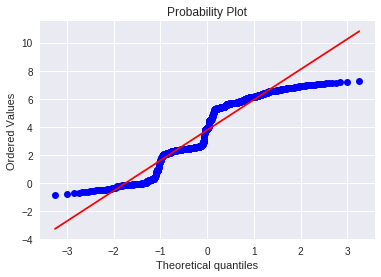

In [0]:
# Get the list with seconds since earliest event
df_hashrate.Tx_Date = [(i - min(df_hashrate.Tx_Date)).total_seconds() for i in df_hashrate.Tx_Date]

# Normalize data so it lies between 0 and 1
df_hashrate.Tx_Date = [i/max(df_hashrate.Tx_Date) for i in df_hashrate.Tx_Date]
#print(df_hashrate.Tx_Date)


import math
# log transform the response 'price'
print(min(df_hashrate.price))
df_hashrate['price_log'] = df_hashrate['price'].apply(lambda x: math.log(x))

import pylab
import scipy.stats as stats
stats.probplot(df_hashrate['price_log'], dist="norm", plot=pylab)
pylab.show()

In [0]:
# convert non-categorical variables to floats and standardize
def standardize_col(col):
    mean = np.mean(col)
    std = np.std(col)
    return col.apply(lambda x: (x - mean) / std)
             
non_cat_vars = ['Block_Count', 'Difficulty', 'AVG_TIME', 'NetHashRate', 'spam_count', 'sum_tx_ether', 'avg_tx_gas_cost', 'supply']
for col in non_cat_vars:
    df_hashrate[col] = df_hashrate[col].astype(float)
    df_hashrate[col] = standardize_col(df_hashrate[col])
    
df_hashrate.head(5)

,Tx_Date,Block_Count,Difficulty,AVG_TIME,NetHashRate,spam_count,sum_tx_ether,avg_tx_gas_cost,supply,price,Risky--,Risky-,Neutral,Stable+,Stable++,price_log
0,0.000000,-0.557552,-0.889262,0.286019,-0.858844,-0.775298,-0.483403,7.626503,-1.803941,3.00,0,0,0,0,0,1.098612
1,0.000816,-0.462407,-0.889178,0.211986,-0.858754,-0.775106,1.354023,19.223528,-1.800981,1.20,0,0,0,0,0,0.182322
2,0.001631,-0.651278,-0.889087,0.360841,-0.858701,-0.775521,-0.617270,6.623454,-1.798103,1.20,0,0,0,0,0,0.182322
3,0.002447,-0.463827,-0.888993,0.213077,-0.858586,-0.739768,-0.537030,11.957656,-1.795157,1.20,0,0,0,0,0,0.182322
4,0.003263,-0.428325,-0.888847,0.185924,-0.858447,-0.739576,-0.566427,0.809380,-1.792188,0.99,0,0,0,0,0,-0.010050


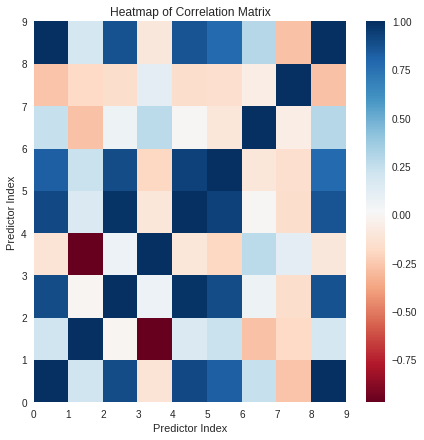

In [0]:
# Compute matrix of correlation coefficients
eth_data1 = df_hashrate[['Tx_Date', 'Block_Count', 'Difficulty', 'AVG_TIME', 'NetHashRate', 'spam_count', 'sum_tx_ether', 'avg_tx_gas_cost', 'supply']]
corr_matrix = np.corrcoef(eth_data1.T)

corr_df = pd.DataFrame(data = corr_matrix, columns = eth_data1.columns, 
             index = eth_data1.columns)
# Display heat map 
plt.figure(figsize=(7, 7))
plt.pcolor(corr_matrix, cmap='RdBu')
plt.xlabel('Predictor Index')
plt.ylabel('Predictor Index')
plt.title('Heatmap of Correlation Matrix')
plt.colorbar()

plt.show()

### Data Modelling

In [0]:
list(df_hashrate)

['Tx_Date',
 'Block_Count',
 'Difficulty',
 'AVG_TIME',
 'NetHashRate',
 'spam_count',
 'sum_tx_ether',
 'avg_tx_gas_cost',
 'supply',
 'price',
 'Risky--',
 'Risky-',
 'Neutral',
 'Stable+',
 'Stable++',
 'price_log']

In [0]:
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.model_selection import KFold # import KFold
from statistics import mean

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers import LSTM
from keras.optimizers import RMSprop
import numpy as np
import random
from sklearn.model_selection import train_test_split

import keras
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout


Using TensorFlow backend.


In [0]:
df_hashrate_train = df_hashrate.drop(columns=['price', 'price_log'])
df_hashrate_price = df_hashrate['price_log']


In [0]:
X_train, X_test, Y_train, Y_test = train_test_split(df_hashrate_train, df_hashrate_price, test_size=0.2, random_state=42)

In [0]:
#Baseline Model

NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(60, kernel_initializer='normal',input_dim = X_train.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(30, kernel_initializer='normal',activation='relu'))
#NN_model.add(Dropout(rate=0.1))
NN_model.add(Dense(10, kernel_initializer='normal',activation='relu'))
#NN_model.add(Dropout(rate=0.1))

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
NN_model.compile(loss='mse', optimizer='adam')
NN_model.summary()

checkpoint_name = '/content/drive/My Drive/Colab Notebooks/Weights.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
earlystopping = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5, verbose=0, mode='auto')
callbacks_list = [checkpoint, earlystopping]

NN_model.fit(X_train, Y_train, epochs=100, batch_size=72, validation_split = 0.2, callbacks=callbacks_list)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 60)                900       
_________________________________________________________________
dense_2 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                310       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
Total params: 3,051
Trainable params: 3,051
Non-trainable params: 0
_________________________________________________________________
Train on 784 samples, validate on 197 samples
Epoch 1/100
784/784 [==============================] - 1s 1ms/step - loss: 19.0712 - val_loss: 19.9710

Epoch 00001: val_loss improved from inf to 19.97101, saving model to /content/drive/My Drive/Colab Notebooks/Weights.hdf5


In [0]:
#With Dropout

NN_model1 = Sequential()

# The Input Layer :
NN_model1.add(Dense(60, kernel_initializer='normal',input_dim = X_train.shape[1], activation='relu'))

# The Hidden Layers :
NN_model1.add(Dense(30, kernel_initializer='normal',activation='relu'))
NN_model1.add(Dropout(rate=0.1))
NN_model1.add(Dense(10, kernel_initializer='normal',activation='relu'))
NN_model1.add(Dropout(rate=0.1))

# The Output Layer :
NN_model1.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
NN_model1.compile(loss='mse', optimizer='adam')
NN_model1.summary()

checkpoint_name = '/content/drive/My Drive/Colab Notebooks/Weights.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
earlystopping = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5, verbose=0, mode='auto')
callbacks_list = [checkpoint, earlystopping]

NN_model1.fit(X_train, Y_train, epochs=100, batch_size=72, validation_split = 0.2, callbacks=callbacks_list)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 60)                900       
_________________________________________________________________
dense_6 (Dense)              (None, 30)                1830      
_________________________________________________________________
dropout_1 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)                310       
_________________________________________________________________
dropout_2 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 11        
Total params: 3,051
Trainable params: 3,051
Non-trainable params: 0
_________________________________________________________________
Train on

In [0]:
#LSTM Model
X_test1 = X_test.as_matrix()
X_train = X_train.as_matrix().reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.as_matrix().reshape((X_test.shape[0], 1, X_test.shape[1]))
# design network
NN_model2 = Sequential()
NN_model2.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
NN_model2.add(Dense(1))
NN_model2.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

checkpoint_name = '/content/drive/My Drive/Colab Notebooks/Weights.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
earlystopping = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5, verbose=0, mode='auto')
callbacks_list = [checkpoint, earlystopping]

NN_model2.fit(X_train, Y_train, epochs=100, batch_size=72, validation_split = 0.2, callbacks=callbacks_list)


Train on 784 samples, validate on 197 samples
Epoch 1/100
784/784 [==============================] - 1s 1ms/step - loss: 18.1557 - acc: 0.0026 - val_loss: 17.9627 - val_acc: 0.0051

Epoch 00001: val_loss improved from inf to 17.96274, saving model to /content/drive/My Drive/Colab Notebooks/Weights.hdf5
Epoch 2/100
784/784 [==============================] - 0s 145us/step - loss: 15.9783 - acc: 0.0026 - val_loss: 15.7633 - val_acc: 0.0051

Epoch 00002: val_loss improved from 17.96274 to 15.76328, saving model to /content/drive/My Drive/Colab Notebooks/Weights.hdf5
Epoch 3/100
784/784 [==============================] - 0s 149us/step - loss: 13.8558 - acc: 0.0026 - val_loss: 13.6330 - val_acc: 0.0051

Epoch 00003: val_loss improved from 15.76328 to 13.63302, saving model to /content/drive/My Drive/Colab Notebooks/Weights.hdf5
Epoch 4/100
784/784 [==============================] - 0s 152us/step - loss: 11.8568 - acc: 0.0026 - val_loss: 11.5887 - val_acc: 0.0051

Epoch 00004: val_loss improv

### Evaluation

In [0]:
MAE =[]
R2_Score =[]

In [0]:
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_absolute_error, median_absolute_error, r2_score

y_predicted = NN_model.predict(X_test)
print("MAE:  %.2f" % mean_absolute_error(Y_test, y_predicted))
print("R2 Score:  %.2f%%" % (r2_score(Y_test, y_predicted)*100))
MAE.append(mean_absolute_error(Y_test, y_predicted))
R2_Score.append(r2_score(Y_test, y_predicted)*100)

MAE:  0.30
R2 Score:  97.06%


In [0]:
y_predicted1 = NN_model1.predict(X_test)
mean_absolute_error(Y_test, y_predicted1)
r2_score(Y_test, y_predicted1)
print("MAE:  %.2f" % mean_absolute_error(Y_test, y_predicted1))
print("R2 Score:  %.2f%%" % (r2_score(Y_test, y_predicted1)*100))

MAE.append(mean_absolute_error(Y_test, y_predicted1))
R2_Score.append(r2_score(Y_test, y_predicted1)*100)

MAE:  0.39
R2 Score:  94.76%


In [0]:
y_predicted2 = NN_model2.predict(X_test)
print("MAE:  %.2f" % mean_absolute_error(Y_test, y_predicted2))
print("R2 Score:  %.2f%%" % (r2_score(Y_test, y_predicted2)*100))

MAE.append(mean_absolute_error(Y_test, y_predicted2))
R2_Score.append(r2_score(Y_test, y_predicted2)*100)

MAE:  0.29
R2 Score:  96.45%


In [0]:
print(MAE)
print(R2_Score)

[0.2987678514484293, 0.38983845708616915, 0.29131924628481165]
[97.05711247365059, 94.76485807776885, 96.45032133323208]


## ICO Returns Classification

**In this stage, data related to ICO like funding amount, start date, end date, hype factors is collected. The predicted prices from Stage 1 is integrated in the ICO dataset. The dataset is then classified into five categories based on their stability and return prediction.**

### Data Exploration

In [0]:
ico_data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/ICO_Data.csv")

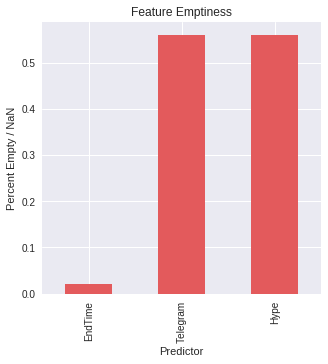

In [0]:
def percent_empty(df):
    
    bools = df.isnull().tolist()
    percent_empty = float(bools.count(True)) / float(len(bools))
    
    return percent_empty, float(bools.count(True))

# Store emptiness for all features
emptiness = []

missing_columns = []

# Get emptiness for all features
for i in range(0, ico_data.shape[1]):
    p, n = percent_empty(ico_data.iloc[:,i])
    if n > 0:
        missing_columns.append(ico_data.columns.values[i])
    emptiness.append(round((p), 2))
    
empty_dict = dict(zip(ico_data.columns.values.tolist(), emptiness))

# Create a temporary copy of dictionary
copyOfDict = dict(empty_dict)
 
# Iterate over the temporary dictionary and delete corresponding key from original dictionary
for (key, value) in copyOfDict.items() :
    if value % 3 == 0:
        del empty_dict[key]

# Plot emptiness graph
empty = pd.DataFrame.from_dict(empty_dict, orient = 'index').sort_values(by=0)
ax = empty.plot(kind = 'bar', color='#E35A5C', figsize = (5, 5))
ax.set_xlabel('Predictor')
ax.set_ylabel('Percent Empty / NaN')
ax.set_title('Feature Emptiness')
ax.legend_.remove()

Empty values of "End Time", 'Telegram' and 'Hype'  is removed from dataset. 


In [0]:
ico_data.shape

(1802, 9)

In [0]:
ico_data.iloc[811,5] = 77
ico_data.iloc[812,5] = 5812
ico_data.iloc[813,5] = 1748
ico_data = ico_data[ico_data.Name != 'Ended']
ico_data = ico_data[ico_data.Name != 'Failed']
ico_data = ico_data.dropna(subset=['EndTime', 'Telegram', 'Hype', 'Rating', 'Current_Price'])
ico_data = ico_data[ico_data.Token_Price > 0]

ico_data.USD_Raised = ico_data.USD_Raised.astype(float)
ico_data.Telegram = ico_data.Telegram.astype(float)

In [0]:
import random
import datetime

ico_data.Rating = ico_data.Rating.apply(lambda x: random.uniform(1, 80) if x < 1 else x)
ico_data.Return = ico_data.Return.apply(lambda x: random.uniform(1, 5) if x < 0.1 else x)
ico_data.EndTime = [datetime.datetime.strptime(x, '%d.%m.%Y').date() for x in ico_data.EndTime]

ico_data.USD_Raised = ico_data.USD_Raised.apply(lambda x: random.randint(min(ico_data.USD_Raised), max(ico_data.USD_Raised)) if x < 1 else x)

ico_data = ico_data.drop(columns=['Name'])
ico_data.shape

(561, 8)

In [0]:
ico_data.head(5)

,USD_Raised,EndTime,Token_Price,Current_Price,Telegram,Hype,Return,Rating
1,258000000.0,2017-12-22,0.810000,0.000000,3577.0,49.0,4.555469,8.986246
5,157885825.0,2017-12-26,1.530000,0.000000,93814.0,97.0,1.466028,51.818142
6,153000000.0,2017-06-12,3.856624,0.564342,7143.0,73.0,0.146000,58.247865
7,151800000.0,2018-02-28,0.020700,0.000000,17838.0,85.0,4.362341,23.737308
12,100000000.0,2018-01-15,0.700000,0.000000,16645.0,85.0,3.538321,70.274998


### Data Preparation

In [0]:
#@title Dataset is populated with the assumption that all ICOs start from a single date, and end on different dates to predict all possible durations for ICOs to be active
import math
import random
from datetime import date, timedelta
import datetime

temp_ico = pd.DataFrame(columns = ['USD_Raised', 'EndTime', 'Token_Price', 'Current_Price', 'Telegram', 'Hype', 'Return', 'Rating'])

for index, row in ico_data.iterrows():
  end = row["EndTime"]
  current = datetime.date(2015,8,7)
  if row['Current_Price'] < 0.1:
    row['Current_Price'] = random.uniform(0.3, 1) * row['Token_Price'] 
  while current <= end:
    current += timedelta(days = 15)
    temp_ico = temp_ico.append({'USD_Raised': random.uniform(0.9, 1.1) * row["USD_Raised"],
                            'EndTime': current,
                            'Token_Price': random.uniform(0.9, 1.1) * row["Token_Price"], 
                            'Current_Price': random.uniform(0.9, 1.1) * row["Current_Price"], 
                            'Telegram': random.uniform(0.9, 1.1) * row["Telegram"], 
                            'Hype':random.uniform(0.9, 1.1) * row["Hype"],
                            'Return': random.uniform(0.9, 1.1) * row["Return"],
                            'Rating':random.uniform(0.9, 1.1) * row["Rating"]} , ignore_index=True)
#print(temp_ico.shape)
ico_data = pd.concat([ico_data, temp_ico])
ico_data.shape

(35838, 8)

In [0]:
ico_data = ico_data.reset_index(drop=True)

**The predicted prices of Stage 1 is integrated in the ICO dataset**

In [0]:
temp1 = []
eth_price = []
for index, row in ico_data.iterrows():
  row['Rating'] = random.uniform(0.6,0.7) * row['Return']
  row['Telegram'] = random.uniform(100,110) * row['Return']
  temp1.append(df_hashrate1.loc[df_hashrate1['Tx_Date'] == row['EndTime'], 'price'].values)
for i in temp1:
  if len(i) == 0:
    eth_price.append(0)
  else:
    eth_price.append(i[0])
  
ico_data['eth_price'] = eth_price
ico_data.head(5)

,USD_Raised,EndTime,Token_Price,Current_Price,Telegram,Hype,Return,Rating,eth_price
0,258000000.0,2017-12-22,0.810000,0.000000,3577.0,49.0,4.555469,8.986246,657.83
1,157885825.0,2017-12-26,1.530000,0.000000,93814.0,97.0,1.466028,51.818142,753.40
2,153000000.0,2017-06-12,3.856624,0.564342,7143.0,73.0,0.146000,58.247865,394.66
3,151800000.0,2018-02-28,0.020700,0.000000,17838.0,85.0,4.362341,23.737308,851.50
4,100000000.0,2018-01-15,0.700000,0.000000,16645.0,85.0,3.538321,70.274998,1278.69


In [0]:
ico_data.to_csv('/content/drive/My Drive/Colab Notebooks/df_ico_initial.csv', index=False)

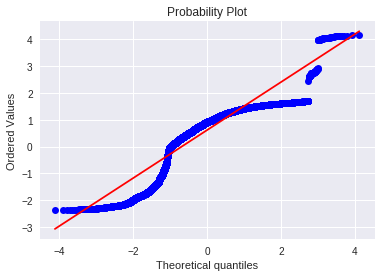

In [0]:
ico_data['Return_log'] = ico_data['Return'].apply(lambda x: (math.log(x)))
import pylab
import scipy.stats as stats
stats.probplot(ico_data['Return_log'], dist="norm", plot=pylab)
pylab.show()

In [0]:
ico_data.dtypes

USD_Raised       float64
EndTime           object
Token_Price      float64
Current_Price    float64
Telegram         float64
Hype             float64
Return           float64
Rating           float64
eth_price        float64
Return_log       float64
dtype: object

In [0]:
#@title The performanc of ICOs can vary depending on their domain and audience. Thus, we have added two more features - Audience and Type of ICO to our dataset.
class_list = []
type_list = []
audience_list =[]
audience_list1 = ['Banking', 'Government', 'Healthcare', 'Real Estate', 'Ecommerce', 'AI', 'Entertainment', 'Trading']
type_list1 = ['Framework', 'Infrastructure', 'Exchange', 'Utility', 'Application']
for index, row in ico_data.iterrows():
  #print(row['Return'])
  if row['Return'] <= 1.0:
    class_list.append('Risky--')
    audience_list.append(random.choice(audience_list1))
    type_list.append(random.choice(type_list1))
  elif row['Return'] > 1.0 and row['Return'] <= 2.0:
    class_list.append('Risky-')
    audience_list.append(random.choice(audience_list1))
    type_list.append(random.choice(type_list1))
  elif row['Return'] > 2.0 and row['Return'] <= 3.0:
    class_list.append('Neutral')
    audience_list.append(random.choice(audience_list1))
    type_list.append(random.choice(type_list1))
  elif row['Return'] > 3.0 and row['Return'] <= 4.0:
    class_list.append('Stable+')
    audience_list.append(random.choice(audience_list1))
    type_list.append(random.choice(type_list1))
  else:
    class_list.append('Stable++')
    audience_list.append(random.choice(audience_list1))
    type_list.append(random.choice(type_list1))

print(len(class_list))
ico_data['Return_Class'] = class_list
ico_data['Audience'] = audience_list
ico_data['Type'] = type_list

ico_data.head(5)

35838


,USD_Raised,EndTime,Token_Price,Current_Price,Telegram,Hype,Return,Rating,eth_price,Return_log,Return_Class,Audience,Type
0,258000000.0,2017-12-22,0.810000,0.000000,3577.0,49.0,4.555469,8.986246,657.83,1.516328,Stable++,Banking,Application
1,157885825.0,2017-12-26,1.530000,0.000000,93814.0,97.0,1.466028,51.818142,753.40,0.382557,Risky-,Banking,Exchange
2,153000000.0,2017-06-12,3.856624,0.564342,7143.0,73.0,0.146000,58.247865,394.66,-1.924149,Risky--,Banking,Application
3,151800000.0,2018-02-28,0.020700,0.000000,17838.0,85.0,4.362341,23.737308,851.50,1.473009,Stable++,Entertainment,Infrastructure
4,100000000.0,2018-01-15,0.700000,0.000000,16645.0,85.0,3.538321,70.274998,1278.69,1.263652,Stable+,Ecommerce,Utility


### Data Preprocessing

In [0]:
# Get the list with seconds since earliest event
ico_data.EndTime = [(i - min(ico_data.EndTime)).total_seconds() for i in ico_data.EndTime]

# Normalize data so it lies between 0 and 1
ico_data.EndTime = [i/max(ico_data.EndTime) for i in ico_data.EndTime]

import math
# log transform the response 'price'
print(min(ico_data.USD_Raised))
#ico_data['USD_Raised'] = ico_data['USD_Raised'].apply(lambda x: math.log(x/100000))


def standardize_col(col):
    mean = np.mean(col)
    std = np.std(col)
    min1 = np.min(col)
    max1 = np.max(col)
    return col.apply(lambda x: (x - mean)/std)
             
non_cat_vars = ['Token_Price', 'Current_Price', 'Telegram', 'Hype', 'USD_Raised', 'Rating', 'eth_price']
for col in non_cat_vars:
    ico_data[col] = ico_data[col].astype(float)
    ico_data[col] = standardize_col(ico_data[col])
    
ico_data.head(5)

1689.9237761630413


,USD_Raised,EndTime,Token_Price,Current_Price,Telegram,Hype,Return,Rating,eth_price,Return_log,Return_Class,Audience,Type
0,2.935461,0.247168,-0.070664,-0.077873,-0.461882,-0.036110,4.555469,-1.446806,1.963118,1.516328,Stable++,Banking,Application
1,1.491806,0.247977,-0.053690,-0.077873,5.404980,1.618897,1.466028,0.406932,2.338890,0.382557,Risky-,Banking,Exchange
2,1.421352,0.208131,0.001158,-0.063237,-0.230034,0.791394,0.146000,0.685206,0.928357,-1.924149,Risky--,Banking,Application
3,1.404048,0.260922,-0.089271,-0.077873,0.465313,1.205145,4.362341,-0.808389,2.724611,1.473009,Stable++,Entertainment,Infrastructure
4,0.657088,0.252023,-0.073257,-0.077873,0.387749,1.205145,3.538321,1.205733,4.404283,1.263652,Stable+,Ecommerce,Utility


In [0]:
# encode categorical variables
Audience_dummies = pd.get_dummies(ico_data['Audience'])
Type_dummies = pd.get_dummies(ico_data['Type'])
# replace the old columns with our new one-hot encoded ones
ico_data = pd.concat((ico_data.drop(['Audience','Type'], axis=1), Audience_dummies.astype(int), Type_dummies.astype(int)), axis=1)

print(len(ico_data.columns))

24


In [0]:
ico_data.head(5)

,USD_Raised,EndTime,Token_Price,Current_Price,Telegram,Hype,Return,Rating,eth_price,Return_log,...,Entertainment,Government,Healthcare,Real Estate,Trading,Application,Exchange,Framework,Infrastructure,Utility
0,2.935461,0.247168,-0.070664,-0.077873,-0.461882,-0.036110,4.555469,-1.446806,1.963118,1.516328,...,0,0,0,0,0,1,0,0,0,0
1,1.491806,0.247977,-0.053690,-0.077873,5.404980,1.618897,1.466028,0.406932,2.338890,0.382557,...,0,0,0,0,0,0,1,0,0,0
2,1.421352,0.208131,0.001158,-0.063237,-0.230034,0.791394,0.146000,0.685206,0.928357,-1.924149,...,0,0,0,0,0,1,0,0,0,0
3,1.404048,0.260922,-0.089271,-0.077873,0.465313,1.205145,4.362341,-0.808389,2.724611,1.473009,...,1,0,0,0,0,0,0,0,1,0
4,0.657088,0.252023,-0.073257,-0.077873,0.387749,1.205145,3.538321,1.205733,4.404283,1.263652,...,0,0,0,0,0,0,0,0,0,1


In [0]:
#print(df_ico)
ico_data.to_csv('/content/drive/My Drive/Colab Notebooks/df_ico_classification.csv', index=False)

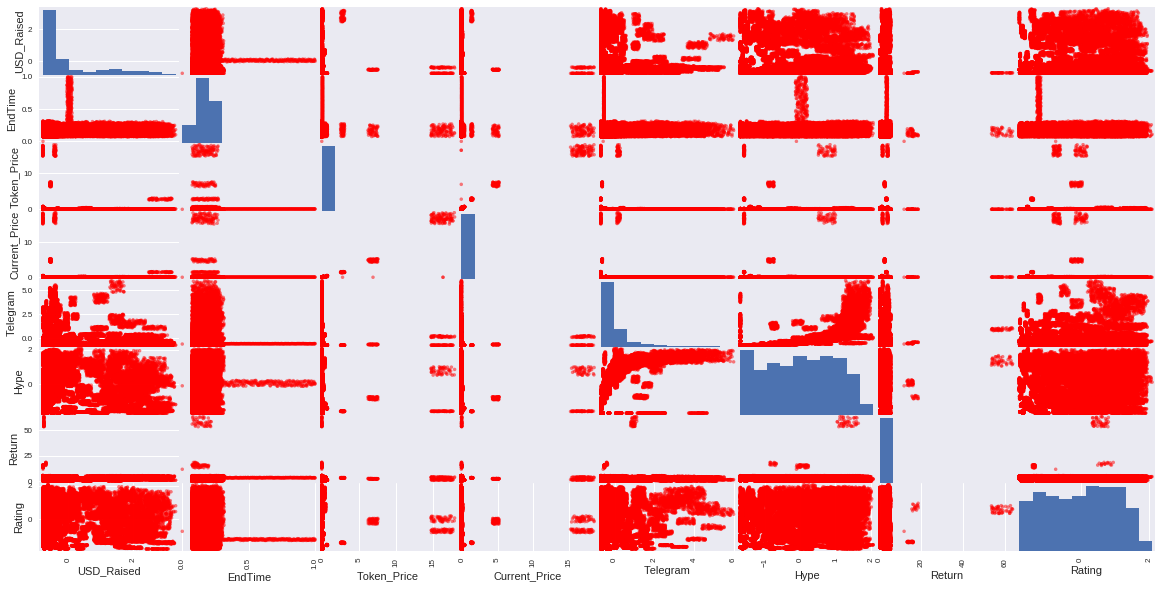

In [0]:
# check for collinearity and visualize relationship between each predictor and price
matrix_cols = ['USD_Raised', 'EndTime', 'Token_Price', 'Current_Price', 'Telegram', 'Hype', 'Return', 'Rating']
axs = pd.plotting.scatter_matrix(ico_data[matrix_cols], figsize=(20, 10), c='red')

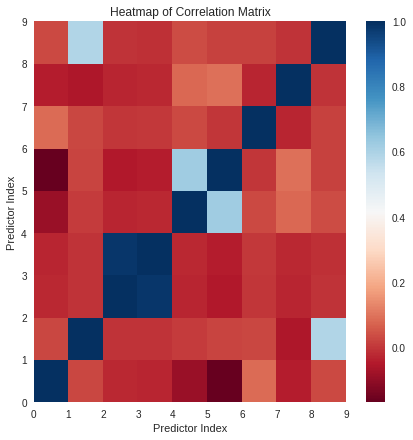

In [0]:
# Compute matrix of correlation coefficients
ico_data1 = ico_data[['USD_Raised', 'EndTime', 'Token_Price', 'Current_Price', 'Telegram', 'Hype', 'Return', 'Rating', 'eth_price']]
corr_matrix = np.corrcoef(ico_data1.T)

corr_df = pd.DataFrame(data = corr_matrix, columns = ico_data1.columns, 
             index = ico_data1.columns)
# Display heat map 
plt.figure(figsize=(7, 7))
plt.pcolor(corr_matrix, cmap='RdBu')
plt.xlabel('Predictor Index')
plt.ylabel('Predictor Index')
plt.title('Heatmap of Correlation Matrix')
plt.colorbar()

plt.show()

### Data Modelling

In [0]:
import numpy
import pandas
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

In [0]:
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

In [0]:
ico_data.dtypes

USD_Raised        float64
EndTime           float64
Token_Price       float64
Current_Price     float64
Telegram          float64
Hype              float64
Return            float64
Rating            float64
eth_price         float64
Return_log        float64
Return_Class       object
AI                  int64
Banking             int64
Ecommerce           int64
Entertainment       int64
Government          int64
Healthcare          int64
Real Estate         int64
Trading             int64
Application         int64
Exchange            int64
Framework           int64
Infrastructure      int64
Utility             int64
dtype: object

In [0]:
ico_train = ico_data.drop(columns=['Return', 'Return_Class', 'Return_log'])
ico_type = ico_data['Return_log']
ico_class = ico_data['Return_Class']
#ico_Audience = ico_data.Audience

In [0]:
#encode class values as integers
encoder = LabelEncoder()
encoder.fit(ico_class)
encoded_Y = encoder.transform(ico_class)
# convert integers to dummy variables (i.e. one hot encoded)
ico_class_y = np_utils.to_categorical(encoded_Y)


In [0]:
ico_class_y.shape

(35838, 5)

In [0]:
from sklearn.model_selection import train_test_split
import keras
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout, LSTM
from keras.optimizers import SGD
from sklearn.metrics import mean_squared_error
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from sklearn.model_selection import KFold 

In [0]:
X_train, X_test, Y_train, Y_test = train_test_split(ico_train, ico_class_y, test_size=0.2, random_state=42)

In [0]:
list(ico_train)

['USD_Raised',
 'EndTime',
 'Token_Price',
 'Current_Price',
 'Telegram',
 'Hype',
 'Rating',
 'eth_price',
 'AI',
 'Banking',
 'Ecommerce',
 'Entertainment',
 'Government',
 'Healthcare',
 'Real Estate',
 'Trading',
 'Application',
 'Exchange',
 'Framework',
 'Infrastructure',
 'Utility']

In [0]:
#Baseline Model

NN_model = Sequential()

NN_model.add(Dense(200, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))
#NN_model.add(Dropout(rate=0.5))
NN_model.add(Dense(100, kernel_initializer='normal', activation='relu'))
#NN_model.add(Dropout(rate=0.5))
NN_model.add(Dense(100, kernel_initializer='normal', activation='relu'))

NN_model.add(Dense(50, kernel_initializer='normal', activation='relu'))

# The Output Layer :
NN_model.add(Dense(ico_class_y.shape[1], kernel_initializer='normal',activation='softmax'))

# Compile the network :
NN_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
NN_model.summary()

checkpoint_name = '/content/drive/My Drive/Colab Notebooks/Weights.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
earlystopping = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10, verbose=0, mode='auto')
callbacks_list = [checkpoint, earlystopping]

# fit network
NN_model.fit(X_train, Y_train, epochs=100, batch_size=64, validation_split = 0.1, verbose=2, callbacks=callbacks_list)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 200)               4400      
_________________________________________________________________
dense_11 (Dense)             (None, 100)               20100     
_________________________________________________________________
dense_12 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_13 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_14 (Dense)             (None, 5)                 255       
Total params: 39,905
Trainable params: 39,905
Non-trainable params: 0
_________________________________________________________________
Train on 25803 samples, validate on 2867 samples
Epoch 1/50
 - 3s - loss: 1.5517 - acc: 0.2676 - val_loss: 1.5321 - val_acc: 0.2836

Epoch

In [0]:
#With Dropout

NN_model1 = Sequential()

NN_model1.add(Dense(200, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))
NN_model1.add(Dropout(rate=0.1))
NN_model1.add(Dense(100, kernel_initializer='normal', activation='relu'))
NN_model1.add(Dropout(rate=0.1))
NN_model1.add(Dense(100, kernel_initializer='normal', activation='relu'))
NN_model1.add(Dropout(rate=0.1))
NN_model1.add(Dense(50, kernel_initializer='normal', activation='relu'))

# The Output Layer :
NN_model1.add(Dense(ico_class_y.shape[1], kernel_initializer='normal',activation='softmax'))

# Compile the network :
NN_model1.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
NN_model1.summary()

checkpoint_name = '/content/drive/My Drive/Colab Notebooks/Weights.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
earlystopping = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10, verbose=0, mode='auto')
callbacks_list = [checkpoint, earlystopping]

# fit network
NN_model1.fit(X_train, Y_train, epochs=100, batch_size=64, validation_split = 0.1, verbose=2, callbacks=callbacks_list)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 200)               4400      
_________________________________________________________________
dropout_8 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 100)               20100     
_________________________________________________________________
dropout_9 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_10 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 50)                5050      
__________

In [0]:
#LSTM Model
X_test1 = X_test.copy()
X_train = X_train.as_matrix().reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.as_matrix().reshape((X_test.shape[0], 1, X_test.shape[1]))

# design network
NN_model2 = Sequential()
NN_model2.add(LSTM(200, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
NN_model2.add(LSTM(100, return_sequences=True))
NN_model2.add(LSTM(100, return_sequences=True))
NN_model2.add(LSTM(50))
NN_model2.add(Dense(ico_class_y.shape[1], activation='softmax'))
NN_model2.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['categorical_accuracy'])
NN_model2.summary()

checkpoint_name = '/content/drive/My Drive/Colab Notebooks/Weights.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
earlystopping = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10, verbose=0, mode='auto')
callbacks_list = [checkpoint, earlystopping]

# fit network
NN_model2.fit(X_train, Y_train, epochs=100, batch_size=64, validation_split = 0.1, callbacks=callbacks_list)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 1, 200)            177600    
_________________________________________________________________
lstm_6 (LSTM)                (None, 1, 100)            120400    
_________________________________________________________________
lstm_7 (LSTM)                (None, 1, 100)            80400     
_________________________________________________________________
lstm_8 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dense_30 (Dense)             (None, 5)                 255       
Total params: 408,855
Trainable params: 408,855
Non-trainable params: 0
_________________________________________________________________
Train on 25803 samples, validate on 2867 samples
Epoch 1/100
25803/25803 [==============================] - 13s 515us/step - loss: 1.556

###Evaluation

In [0]:
Val_Loss = []
Accuracy = []

In [0]:
score = NN_model.evaluate(X_test, Y_test, batch_size = 64)
y_predicted = NN_model.predict(X_test)
print(score)
print("Val_Loss: %.2f" % (score[0]))
print("Accuracy: %.2f%%" % (score[1]*100))
Val_Loss.append(score[0])
Accuracy.append(score[1]*100)

7168/7168 [==============================] - 0s 30us/step
[0.7011938023247889, 0.7486049107142857]
Val_Loss: 0.70
Accuracy: 74.86%


In [0]:
score1 = NN_model1.evaluate(X_test, Y_test, batch_size = 64)
y_predicted1 = NN_model1.predict(X_test)
print(score1)
print("Val_Loss: %.2f" % (score1[0]))
print("Accuracy: %.2f%%" % (score1[1]*100))

Val_Loss.append(score1[0])
Accuracy.append(score1[1]*100)

7168/7168 [==============================] - 0s 32us/step
[0.44431263926838127, 0.8250558035714286]
Val_Loss: 0.44
Accuracy: 82.51%


In [0]:
score2 = NN_model2.evaluate(X_test, Y_test, batch_size = 64)
y_predicted2 = NN_model2.predict(X_test)
print(score2)
print("Val_Loss: %.2f" % (score2[0]))
print("Accuracy: %.2f%%" % (score2[1]*100))

Val_Loss.append(score2[0])
Accuracy.append(score2[1]*100)

7168/7168 [==============================] - 1s 181us/step
[0.4727582951475467, 0.8189174107142857]
Val_Loss: 0.47
Accuracy: 81.89%


In [0]:
print(Val_Loss)
print(Accuracy)

[0.7011938023247889, 0.8456570490130356, 0.44431263926838127, 0.4727582951475467]
[74.86049107142857, 67.67578125, 82.50558035714286, 81.89174107142857]
